In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import argparse, sys
import json
import tqdm
import pickle
import time
from main_tcr_train import *
from merge_Dataset import *
from utils import *
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve
from torch.optim import AdamW
from scipy.sparse import issparse
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.metrics      import silhouette_score
from sklearn.preprocessing   import LabelEncoder
from sklearn.decomposition    import PCA
from sklearn.metrics         import silhouette_score
from matplotlib import font_manager as fm
import logging, matplotlib as mpl
mpl.set_loglevel("warning")
logging.getLogger("fontTools").setLevel(logging.WARNING)
mpl.rcParams.update({
    "font.size": 8,                # 全局默认 8pt
    "axes.titlesize": 10,          # 轴标题 10pt
    "axes.titleweight": "bold",    # 轴标题加粗
    "figure.titlesize": 10,        # figure 级标题 10pt
    "figure.titleweight": "bold",  # figure 级标题加粗
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "legend.title_fontsize": 8,
})


In [2]:
def evaluate(model, val_loader, device):
    true_labels, pred_probs, tcr_embed, rna_embed, joint_emb, attn_scores = validate(model, val_loader, device)
    auc = roc_auc_score(true_labels, pred_probs)

    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    youden = tpr - fpr
    best_idx = np.argmax(youden)
    best_thresh = thresholds[best_idx]

    pred_labels = (pred_probs >= best_thresh).astype(int)
    accuracy = (pred_labels == true_labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='binary', zero_division=0
    )
    return {
        "auc": auc,
        "best_thresh": best_thresh,
        "fpr": fpr,
        "tpr": tpr,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "pred_probs": pred_probs,
        "pred_labels": pred_labels,
    }
# Set display options
pd.set_option('display.max_columns', None)

# --------------------------- Parse config --------------------------- #
argparser = argparse.ArgumentParser()
argparser.add_argument('--config', type=str, default='/data/hxu10/bystander/BTC/config.yaml')
# 在 notebook/pycharm 的 Jupyter 环境中，忽略 sys.argv
IN_JUPYTER = 'ipykernel' in sys.modules
args = argparser.parse_args([] if IN_JUPYTER else None)
config = load_config(args.config)

# Set seed and device
set_random_seed(config['Train']['Trainer_parameter']['random_seed'])
device = config['Train']['Model_Parameter']['device']


In [3]:
adata = sc.read_h5ad("../Data/fintune_raw_data/GSE176021_lung_unique_labels.h5ad")
if issparse(adata.X):
    adata.X = np.array(adata.X.toarray(), dtype=np.float32)
else:
    adata.X = np.array(adata.X, dtype=np.float32)
# Logger
output_dir = config['Train']['output_dir']
logger = get_logger(f"{output_dir}/finetune.log")

epochs = config['Train']['Trainer_parameter']['epoch']
patience = config['Train']['Trainer_parameter']['patience'] // 2

# label_mapping
full_dataset = FinetuneDataset(adata)
_, label_mapping = full_dataset.get_label()

with open("label_mapping.json", "w") as f:
    json.dump(label_mapping, f)


/data/hxu10/bystander/BTC/merge_Dataset.py:160: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  labels = torch.tensor(categories.codes, dtype=torch.long)  # Integer-encoded label tensor


In [4]:
# --------------------------- Initialize and optionally load pretrained model --------------------------- #
model = init_model(config, device)
pretrained_checkpoint = "./TrainingResult/Model_checkpoints/merge_pretrain_after_batchremove_epoch181_model.pth" # merge_pretrain_after_batchremove_512batchsize_epoch135_model.pth
if pretrained_checkpoint:
    model = load_pretrained_model(model, pretrained_checkpoint, device)

In [5]:
# --------------------------- splits by tcr clone type --------------------------- #
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results, fpr_list, tpr_list, auc_list = [], [], [], []
for fold, (train_idx, val_idx) in enumerate(skf.split(adata.X, adata.obs['label']), start=1):
    print(f"\n--- Fold {fold} ---")
    # initial
    model = init_model(config, device)
    model = load_pretrained_model(model, pretrained_checkpoint, device)
    model.to(device)

    # split train and val
    train_adata = adata[train_idx].copy()
    val_adata = adata[val_idx].copy()
    print("Train labels:", train_adata.obs['label'].value_counts().to_dict())
    print(" Val labels:", val_adata.obs['label'].value_counts().to_dict())

    train_loader = DataLoader(
        FinetuneDataset(train_adata),
        batch_size=config['Train']['Sampling']['batch_size'],
        shuffle=config['Train']['Sampling']['sample_shuffle']
    )
    val_loader = DataLoader(
        FinetuneDataset(val_adata, vocab_dict=train_loader.dataset.vocab_dict),
        batch_size=config['Train']['Sampling']['batch_size'],
        shuffle=False
    )

    # Training loop
    min_delta = 0.05
    best_auc, early_stop = -np.inf, 0
    best_epoch_model = None

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        avg_loss, avg_components = finetune_one_epoch(model, train_loader, device, epoch)

        metrics = evaluate(model, val_loader, device)
        auc_score = metrics["auc"]

        logger.info(
            f"Epoch [{epoch}/{epochs}] | Loss: {avg_loss:.5f} | "
            f"Contrastive: {avg_components['tcr']:.5f} | "
            f"Recon: {avg_components['rna']:.5f} | "
            f"Fusion: {avg_components['fusion']:.5f} | "
            f"Class: {avg_components['class']:.5f} | "
            f"Time: {time.time() - start_time:.2f}s"
        )

        # save
        if auc_score > best_auc + min_delta:
            best_auc = auc_score
            early_stop = 0
        else:
            early_stop += 1
            logger.info(
                f"No sufficient improvement for {early_stop}/{patience} epochs."
            )

        if early_stop >= patience:
            best_epoch_model = model.state_dict()
            save_best_model(model, epoch, output_dir, stage="finetune")
            logger.info(
                f"Early stopping at epoch {epoch}. AUC has not improved by ≥{min_delta} for {patience} epochs.")
            break

    if best_epoch_model is not None:
        model.load_state_dict(best_epoch_model)

    final_metrics = evaluate(model, val_loader, device)
    print(f"Fold {fold} final AUC: {final_metrics['auc']:.4f}")
    fold_results.append(final_metrics['auc'])

    # save
    fold_results.append({
        "best_thresh": final_metrics["best_thresh"],
        "accuracy": final_metrics["accuracy"],
        "precision": final_metrics["precision"],
        "recall": final_metrics["recall"],
        "f1": final_metrics["f1"],
        "auc": final_metrics["auc"],
    })
    fpr_list.append(final_metrics["fpr"])
    tpr_list.append(final_metrics["tpr"])
    auc_list.append(final_metrics["auc"])



--- Fold 1 ---
Train labels: {'bystander': 9128, 'tumor': 2080}
 Val labels: {'bystander': 2282, 'tumor': 520}


[2025-08-20 11:20:27,186][2413075373.py][line:54][INFO] Epoch [1/300] | Loss: 4.90346 | Contrastive: 3.15369 | Recon: 1.56323 | Fusion: 0.00089 | Class: 0.62946 | Time: 27.09s
[2025-08-20 11:20:53,465][2413075373.py][line:54][INFO] Epoch [2/300] | Loss: 1.99623 | Contrastive: 3.14456 | Recon: 1.46048 | Fusion: 0.00189 | Class: 0.51520 | Time: 26.27s
[2025-08-20 11:21:18,208][2413075373.py][line:54][INFO] Epoch [3/300] | Loss: 1.74147 | Contrastive: 3.14492 | Recon: 1.41119 | Fusion: 0.00297 | Class: 0.48091 | Time: 24.74s
[2025-08-20 11:21:45,117][2413075373.py][line:54][INFO] Epoch [4/300] | Loss: 1.67709 | Contrastive: 3.14130 | Recon: 1.35769 | Fusion: 0.00343 | Class: 0.47194 | Time: 26.91s
[2025-08-20 11:22:10,906][2413075373.py][line:54][INFO] Epoch [5/300] | Loss: 1.63256 | Contrastive: 3.13916 | Recon: 1.31198 | Fusion: 0.00365 | Class: 0.46706 | Time: 25.78s
[2025-08-20 11:22:38,064][2413075373.py][line:54][INFO] Epoch [6/300] | Loss: 1.59592 | Contrastive: 3.14555 | Recon: 1.

Fold 1 final AUC: 0.9256

--- Fold 2 ---
Train labels: {'bystander': 9128, 'tumor': 2080}
 Val labels: {'bystander': 2282, 'tumor': 520}


[2025-08-20 11:30:44,575][2413075373.py][line:54][INFO] Epoch [1/300] | Loss: 3.00509 | Contrastive: 3.14272 | Recon: 1.54414 | Fusion: 0.00226 | Class: 0.59362 | Time: 27.54s
[2025-08-20 11:31:11,745][2413075373.py][line:54][INFO] Epoch [2/300] | Loss: 1.80085 | Contrastive: 3.15892 | Recon: 1.43795 | Fusion: 0.00668 | Class: 0.50786 | Time: 27.17s
[2025-08-20 11:31:37,506][2413075373.py][line:54][INFO] Epoch [3/300] | Loss: 1.67586 | Contrastive: 3.14613 | Recon: 1.36518 | Fusion: 0.00796 | Class: 0.47790 | Time: 25.76s
[2025-08-20 11:32:04,692][2413075373.py][line:54][INFO] Epoch [4/300] | Loss: 1.61934 | Contrastive: 3.14380 | Recon: 1.29403 | Fusion: 0.00822 | Class: 0.46890 | Time: 27.18s
[2025-08-20 11:32:30,790][2413075373.py][line:54][INFO] Epoch [5/300] | Loss: 1.56802 | Contrastive: 3.13954 | Recon: 1.22134 | Fusion: 0.00781 | Class: 0.46398 | Time: 26.09s
[2025-08-20 11:32:57,253][2413075373.py][line:54][INFO] Epoch [6/300] | Loss: 1.53048 | Contrastive: 3.11770 | Recon: 1.

Fold 2 final AUC: 0.9153

--- Fold 3 ---
Train labels: {'bystander': 9128, 'tumor': 2080}
 Val labels: {'bystander': 2282, 'tumor': 520}


[2025-08-20 11:41:06,545][2413075373.py][line:54][INFO] Epoch [1/300] | Loss: 2.57692 | Contrastive: 3.15895 | Recon: 1.55604 | Fusion: 0.00116 | Class: 0.61744 | Time: 24.43s
[2025-08-20 11:41:34,135][2413075373.py][line:54][INFO] Epoch [2/300] | Loss: 1.77727 | Contrastive: 3.17771 | Recon: 1.46863 | Fusion: 0.00233 | Class: 0.51087 | Time: 27.59s
[2025-08-20 11:42:00,103][2413075373.py][line:54][INFO] Epoch [3/300] | Loss: 1.68358 | Contrastive: 3.17623 | Recon: 1.39174 | Fusion: 0.00273 | Class: 0.47914 | Time: 25.96s
[2025-08-20 11:42:29,115][2413075373.py][line:54][INFO] Epoch [4/300] | Loss: 1.62478 | Contrastive: 3.17498 | Recon: 1.30707 | Fusion: 0.00295 | Class: 0.47061 | Time: 29.01s
[2025-08-20 11:42:57,120][2413075373.py][line:54][INFO] Epoch [5/300] | Loss: 1.57376 | Contrastive: 3.15673 | Recon: 1.23214 | Fusion: 0.00326 | Class: 0.46396 | Time: 28.00s
[2025-08-20 11:43:23,811][2413075373.py][line:54][INFO] Epoch [6/300] | Loss: 1.53399 | Contrastive: 3.15933 | Recon: 1.

Fold 3 final AUC: 0.9194

--- Fold 4 ---
Train labels: {'bystander': 9128, 'tumor': 2080}
 Val labels: {'bystander': 2282, 'tumor': 520}


[2025-08-20 11:52:05,055][2413075373.py][line:54][INFO] Epoch [1/300] | Loss: 3.67377 | Contrastive: 3.16736 | Recon: 1.55399 | Fusion: 0.00104 | Class: 0.58485 | Time: 25.36s
[2025-08-20 11:52:32,103][2413075373.py][line:54][INFO] Epoch [2/300] | Loss: 1.89361 | Contrastive: 3.15484 | Recon: 1.45944 | Fusion: 0.00240 | Class: 0.50399 | Time: 27.05s
[2025-08-20 11:53:00,197][2413075373.py][line:54][INFO] Epoch [3/300] | Loss: 1.72783 | Contrastive: 3.15798 | Recon: 1.40550 | Fusion: 0.00330 | Class: 0.48427 | Time: 28.08s
[2025-08-20 11:53:27,181][2413075373.py][line:54][INFO] Epoch [4/300] | Loss: 1.65497 | Contrastive: 3.16307 | Recon: 1.33612 | Fusion: 0.00374 | Class: 0.47476 | Time: 26.98s
[2025-08-20 11:53:53,095][2413075373.py][line:54][INFO] Epoch [5/300] | Loss: 1.61908 | Contrastive: 3.16870 | Recon: 1.28528 | Fusion: 0.00406 | Class: 0.47030 | Time: 25.91s
[2025-08-20 11:54:20,281][2413075373.py][line:54][INFO] Epoch [6/300] | Loss: 1.57339 | Contrastive: 3.16998 | Recon: 1.

Fold 4 final AUC: 0.9166

--- Fold 5 ---
Train labels: {'bystander': 9128, 'tumor': 2080}
 Val labels: {'bystander': 2282, 'tumor': 520}


[2025-08-20 12:04:22,021][2413075373.py][line:54][INFO] Epoch [1/300] | Loss: 4.17308 | Contrastive: 3.18378 | Recon: 1.56066 | Fusion: 0.00126 | Class: 0.53745 | Time: 26.32s
[2025-08-20 12:04:50,532][2413075373.py][line:54][INFO] Epoch [2/300] | Loss: 1.97438 | Contrastive: 3.18105 | Recon: 1.46941 | Fusion: 0.00205 | Class: 0.48244 | Time: 28.50s
[2025-08-20 12:05:16,512][2413075373.py][line:54][INFO] Epoch [3/300] | Loss: 1.72968 | Contrastive: 3.17685 | Recon: 1.41836 | Fusion: 0.00262 | Class: 0.47287 | Time: 25.97s
[2025-08-20 12:05:44,083][2413075373.py][line:54][INFO] Epoch [4/300] | Loss: 1.65088 | Contrastive: 3.19272 | Recon: 1.35381 | Fusion: 0.00293 | Class: 0.46553 | Time: 27.56s
[2025-08-20 12:06:10,242][2413075373.py][line:54][INFO] Epoch [5/300] | Loss: 1.60759 | Contrastive: 3.17833 | Recon: 1.29366 | Fusion: 0.00305 | Class: 0.45864 | Time: 26.15s
[2025-08-20 12:06:36,329][2413075373.py][line:54][INFO] Epoch [6/300] | Loss: 1.56388 | Contrastive: 3.18508 | Recon: 1.

Fold 5 final AUC: 0.9213


In [ ]:
# save fold_results
torch.save({
    'epoch': epoch,
    'model_state_dict': best_epoch_model,
    'optimizer_state_dict': model.optimizer.state_dict(),
}, f"{config['Train']['output_dir']}/Model_checkpoints/lung_best_model.pth")

In [ ]:
# save
output = {
    "folds": [
        {
            "fold": i+1,
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "auc": float(auc_list[i])
        }
        for i, (fpr, tpr) in enumerate(zip(fpr_list, tpr_list))
    ]
}
output_path = './TrainingResult/AUROC/lung_BTC_roc_data_5fold.json'
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2)


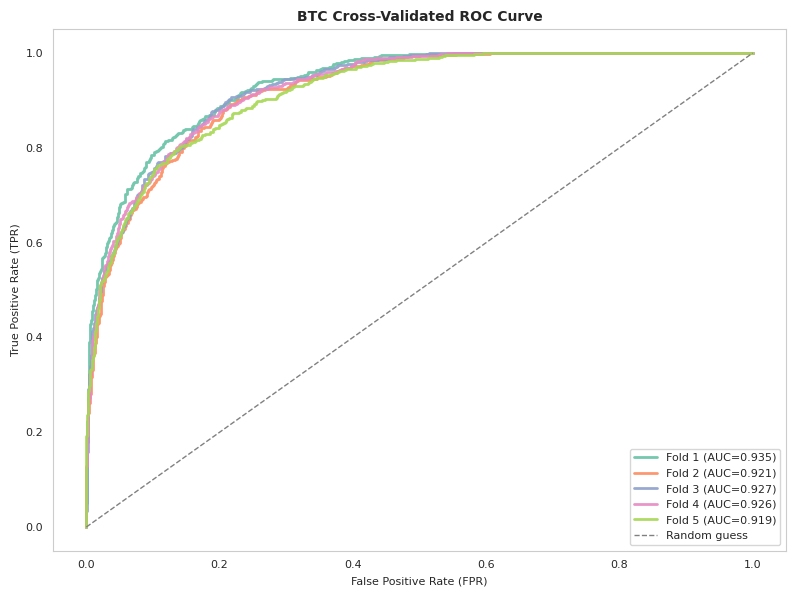

In [13]:
########################## AU-ROC
mean_fpr = np.linspace(0,1,200)
mean_tpr = np.zeros_like(mean_fpr)
for fpr, tpr in zip(fpr_list, tpr_list):
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
cmap = plt.get_cmap("Set2")
n_folds = len(fpr_list)
all_colors = [cmap(x) for x in np.linspace(1, 0, n_folds + 1)]
fold_colors = all_colors[:-1]

plt.figure(figsize=(8,6))
for i,(fpr, tpr, auc_score) in enumerate(zip(fpr_list, tpr_list, auc_list)):
    plt.plot(fpr, tpr,
             color=fold_colors[i],
             alpha=0.6,
             label=f'Fold {i+1} (AUC={auc_score:.3f})')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         linewidth=1,
         color='grey',
         label='random guess')
plt.plot([0,1],[0,1],'--', linewidth=1, color='grey')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('BTC Cross-Validated ROC Curve')
plt.legend(loc='lower right')
plt.grid(False)
plt.savefig("./TrainingResult/AUROC/lung_BTC_Cross-Validated_ROC_Curve.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
all_loader = DataLoader(full_dataset, batch_size=config['Train']['Sampling']['batch_size'], shuffle=False)
model.eval()
joint_embeds, attn_scores, rna_embeds, tcr_embeds, labels, preds = [], [], [], [], [], []
with torch.no_grad():
    for TCR_beta, gene_matrix, _, label, _ in all_loader:
        TCR_beta = TCR_beta.to(device)
        gene_matrix = gene_matrix.to(device)
        label_np = label.numpy()
        _, _, _, _, _, _, z_joint, attn_score, rna_embed, tcr_embed, pred = model.finetune_forward(
            TCR_beta,
            gene_matrix,
            label.to(device).float()
        )
        joint_embeds.append(z_joint.cpu().numpy())
        rna_embeds.append(rna_embed.cpu().numpy())
        tcr_embeds.append(tcr_embed.cpu().numpy())
        preds.append(pred.cpu().numpy())
        attn_scores.append(attn_score)
        labels.append(label_np)

joint_embeds = np.concatenate(joint_embeds, axis=0)
rna_embeds = np.concatenate(rna_embeds, axis=0)
tcr_embeds = np.concatenate(tcr_embeds, axis=0)
labels = np.concatenate(labels, axis=0)
preds = np.concatenate(preds, axis=0)
print("val all")
umap_embedding = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42,metric='cosine').fit_transform(joint_embeds) # metric='cosine'
rna_umap_embedding = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42).fit_transform(rna_embeds)
tcr_umap_embedding = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42).fit_transform(tcr_embeds)
print("umap over")

val all


/data/hxu10/conda_envs/bystander/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/data/hxu10/conda_envs/bystander/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/data/hxu10/conda_envs/bystander/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/data/hxu10/conda_envs/bystander/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


umap over


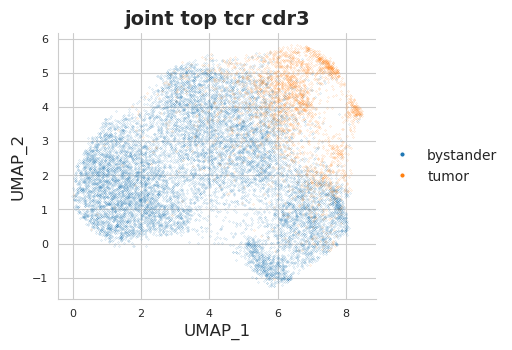

In [9]:
visiual_label = adata.obs["label"] # GSE_adata.obs["label"] # data.obs["label"]
draw_umap = umap_embedding  # data.obsm['gene_umap']

unique_labels = np.unique(visiual_label)
label_counts = Counter(visiual_label)
top_labels = [label for label, _ in label_counts.most_common(5)]
top_colors = [plt.cm.tab10(i) for i in range(len(top_labels))]
label2color = {label: top_colors[i] for i, label in enumerate(top_labels)}
fig, ax = plt.subplots(figsize=(5, 4))
for label in unique_labels:
    mask = visiual_label == label
    color = label2color.get(label, 'lightgray')
    plt.scatter(
        draw_umap[mask, 0],
        draw_umap[mask, 1],
        color=color,
        s=0.01,
        label=label if label in top_labels else None,
        rasterized=True
    )
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=label2color[label],
           label=label, markersize=4)
    for label in top_labels
]
plt.legend(handles=legend_handles, loc='center left',
           bbox_to_anchor=(1.02, 0.5),
           markerscale=1, fontsize=10, title_fontsize=12, borderaxespad=0, frameon=False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('joint top tcr cdr3', fontsize=14, fontweight='bold')
plt.xlabel('UMAP_1', fontsize=12)
plt.ylabel('UMAP_2', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()
